In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
# from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

## layers

In [12]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        # Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W) + self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdw = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdw
        self.b = self.b - learning_rate * self.dLdb

In [3]:
class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1. / (1 + np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s * (1 - self.s) * dLdy

    def step(self, learning_rate):
        pass

In [15]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p) * self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]

In [5]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)

## Семинар 2 "Распознавание рукописных цифр"

ФИО: **Дарханов Евгений Владленович**

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [ ]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

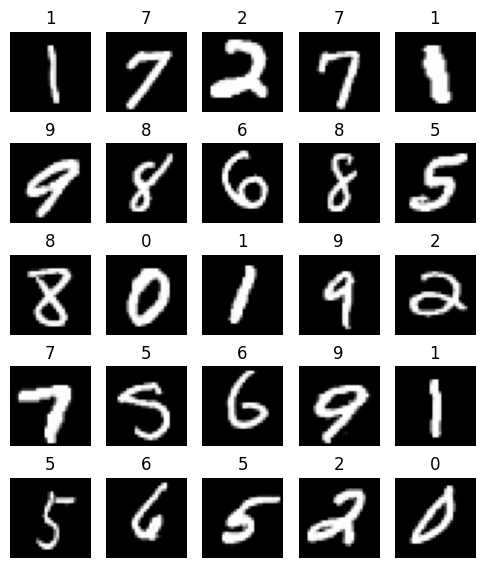

In [8]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [32]:
def train(network, epochs, learning_rate,
          plot=True, verbose=True, loss=None):

    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [18]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.310/0.306	Accuracy: 0.919/0.919

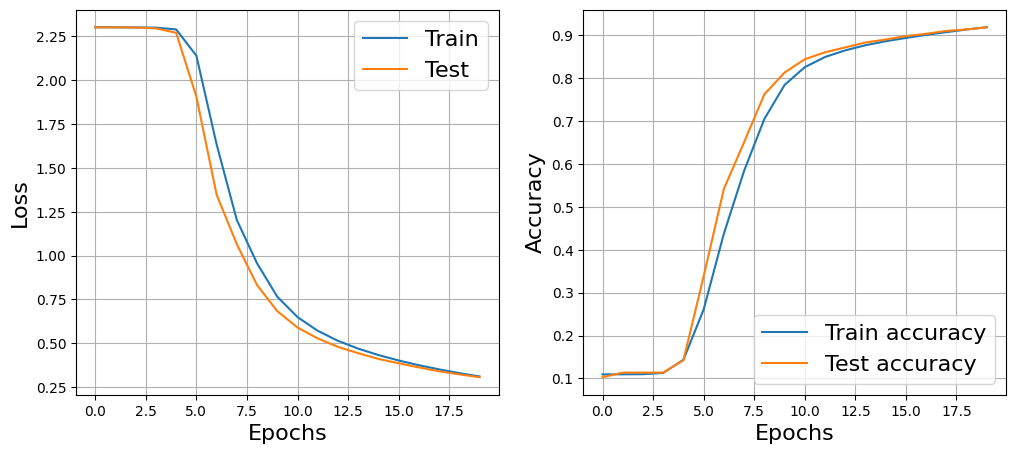

CPU times: user 11min 57s, sys: 8min 3s, total: 20min 1s
Wall time: 11min 37s


In [19]:
%%time
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [20]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [ ]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [21]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.039/0.083	Accuracy: 0.989/0.975

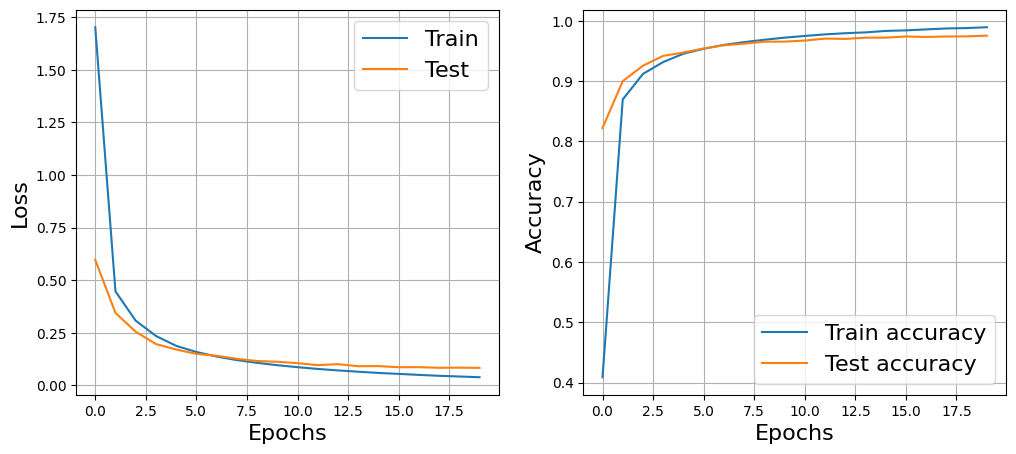

In [22]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.045/0.079	Accuracy: 0.987/0.976

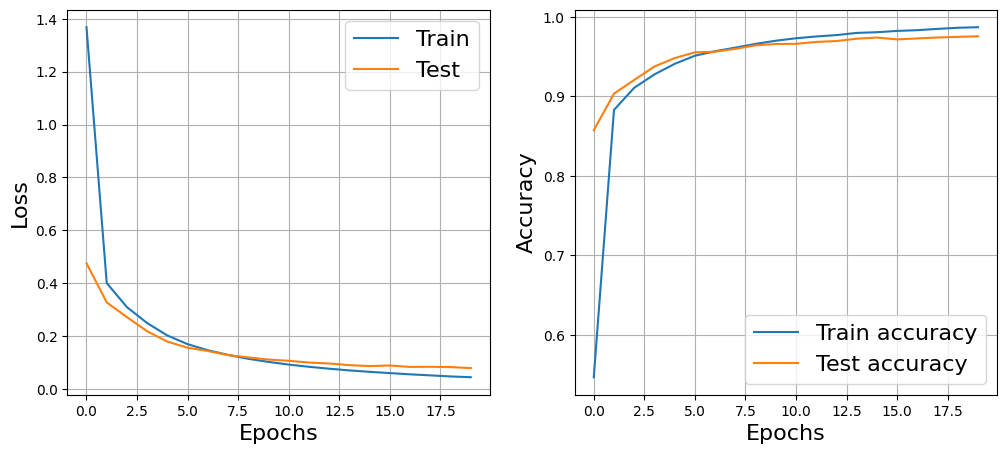

CPU times: user 12min 4s, sys: 8min 10s, total: 20min 15s
Wall time: 11min 45s


In [26]:
%%time
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [23]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.t = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return self.t

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 + self.t) * (1 - self.t) * dLdy

    def step(self, learning_rate):
        pass

In [24]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.031/0.076	Accuracy: 0.993/0.977

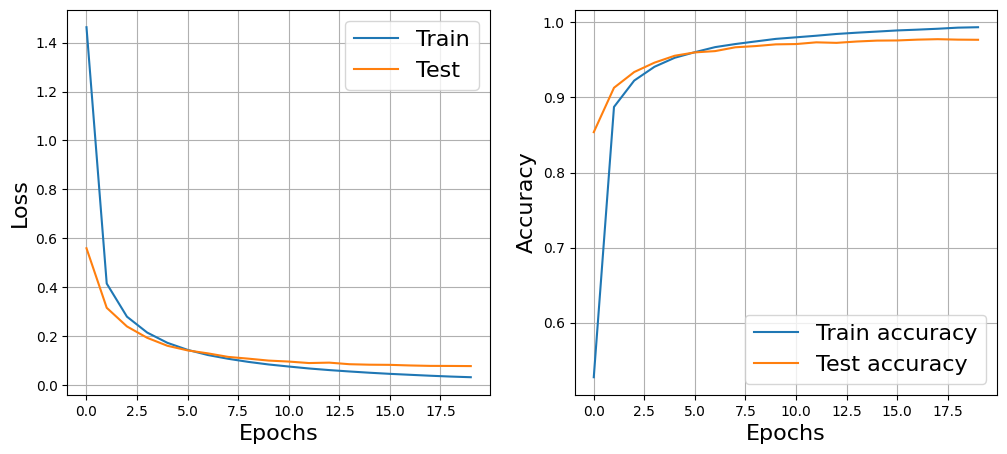

CPU times: user 12min 31s, sys: 8min 33s, total: 21min 4s
Wall time: 12min 51s


In [25]:
%%time
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01)

### Часть 3: Анализ ошибок

In [ ]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

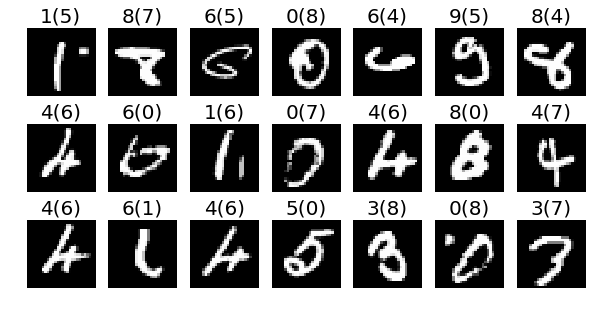

In [ ]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [34]:
import torch

**Будем обучать сеть с тангенсом**

**Небольшие вращения (-15, 15)**

In [31]:
transform_rot = transforms.Compose([
                        transforms.RandomRotation((-15, 15)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset_rot = MNIST('.', train=True, download=True, transform=transform_rot)
test_dataset_rot = MNIST('.', train=False, transform=transform_rot)

train_loader = DataLoader(train_dataset_rot, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_rot, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.067/0.083	Accuracy: 0.980/0.975

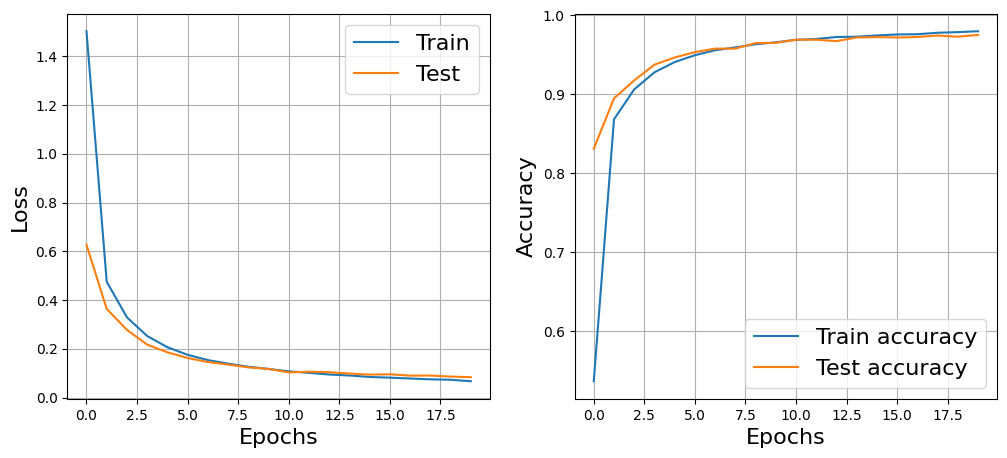

CPU times: user 17min 1s, sys: 11min 57s, total: 28min 58s
Wall time: 19min 43s


In [33]:
%%time

network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_rot, ts_t_rot, tr_ac_t_rot, ts_ac_t_rot = train(network, 20, 0.01)

**Случайные сдвиги**

In [35]:
transform_aff = transforms.Compose([
                        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset_aff = MNIST('.', train=True, download=True, transform=transform_aff)
test_dataset_aff = MNIST('.', train=False, transform=transform_aff)

train_loader = DataLoader(train_dataset_aff, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_aff, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.212/0.202	Accuracy: 0.934/0.940

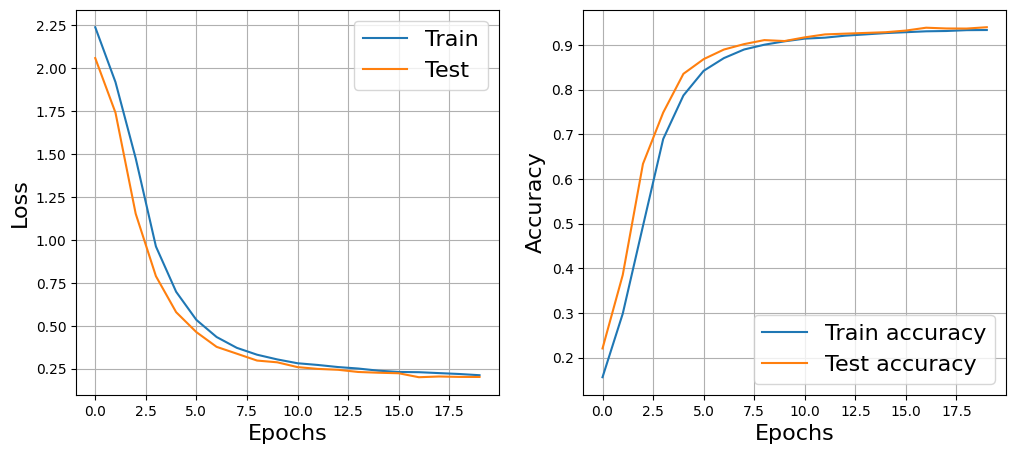

CPU times: user 17min 30s, sys: 12min 8s, total: 29min 38s
Wall time: 17min 6s


In [36]:
%%time

network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_aff, ts_t_aff, tr_ac_t_aff, ts_ac_t_aff = train(network, 20, 0.01)

**Шум**

In [43]:
transform_noise = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))
                    ])

train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset_noise = MNIST('.', train=False, transform=transform_noise)

train_loader = DataLoader(train_dataset_noise, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_noise, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.031/0.078	Accuracy: 0.993/0.976

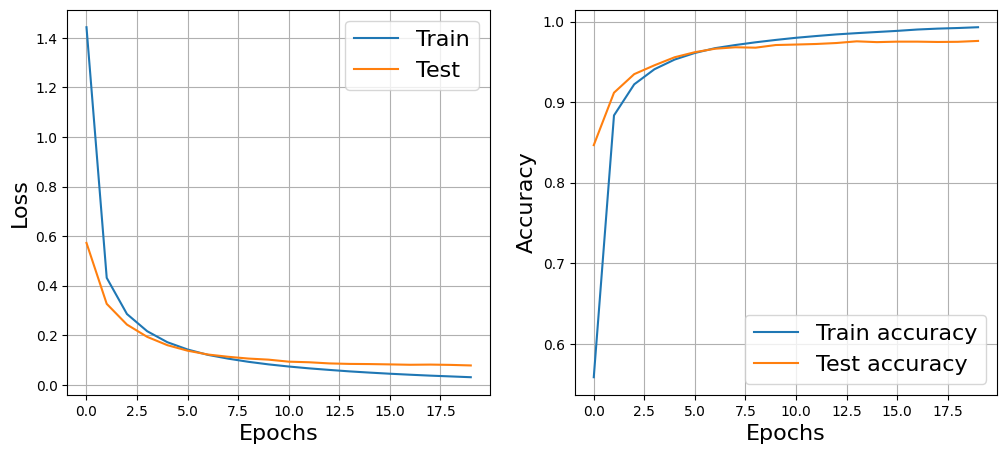

CPU times: user 13min 49s, sys: 9min 28s, total: 23min 18s
Wall time: 13min 22s


In [44]:
%%time

network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_noise, ts_t_noise, tr_ac_t_noise, ts_ac_t_noise = train(network, 20, 0.01)

**Всё вместе**

In [45]:
transform_aug = transforms.Compose([
                        transforms.RandomRotation((-15, 15)),
                        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))
                    ])

train_dataset_aug = MNIST('.', train=True, download=True, transform=transform_aug)
test_dataset_aug = MNIST('.', train=False, transform=transform_aug)

train_loader = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_aug, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.278/0.251	Accuracy: 0.914/0.921

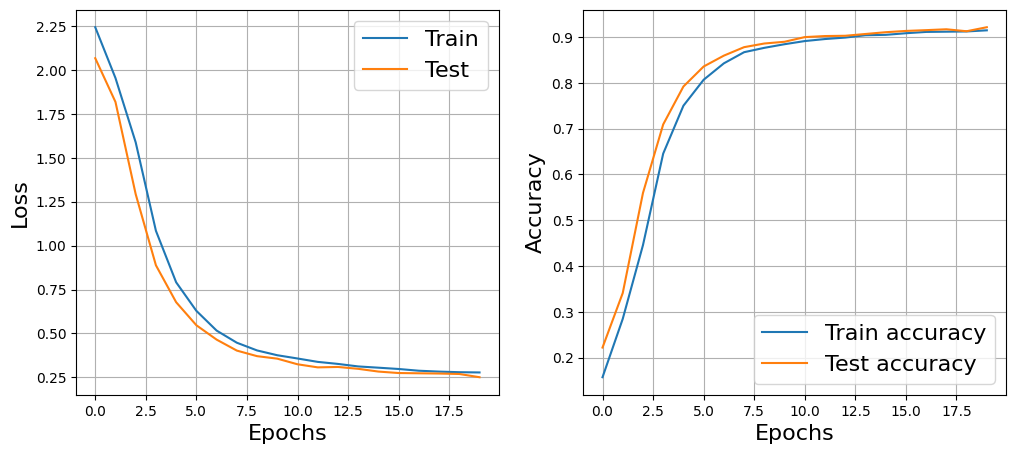

CPU times: user 21min 44s, sys: 15min 18s, total: 37min 2s
Wall time: 21min 8s


In [46]:
%%time

network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_aug, ts_t_aug, tr_ac_t_aug, ts_ac_t_aug = train(network, 20, 0.01)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

**Если смотреть на графики loss и accuracy, то кажется, что сигмоида чувствует себя менее уверенно, чем остальные нелинейности**

**Tanh, ReLU, ELU на этих данных работают плюс-минус одинаково**

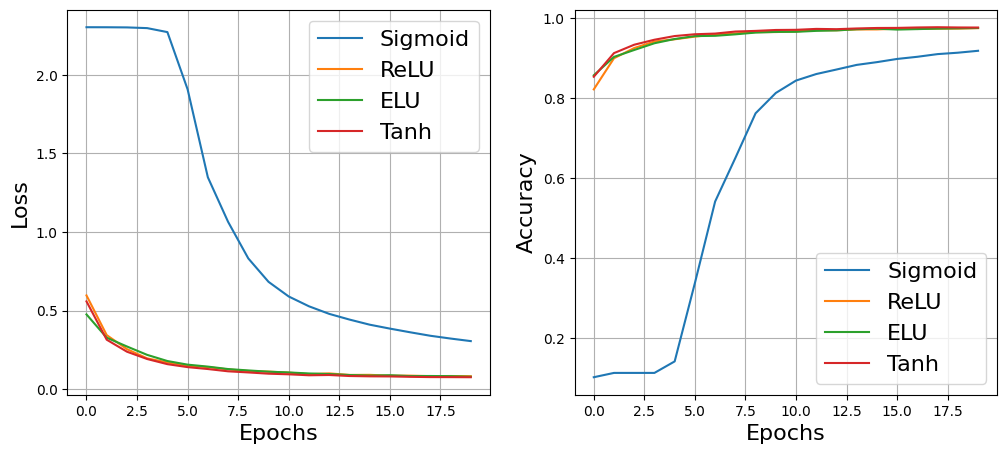

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
# plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

**Сеть с аугментациями обучается дольше, но результат не всегда закономерно лучше**

**В нашем случае оказалось, что:**
- **влияния поворотов и шума почти нет**
- **сдвиги и добавление всех аугментаций наоборот снижают качество**

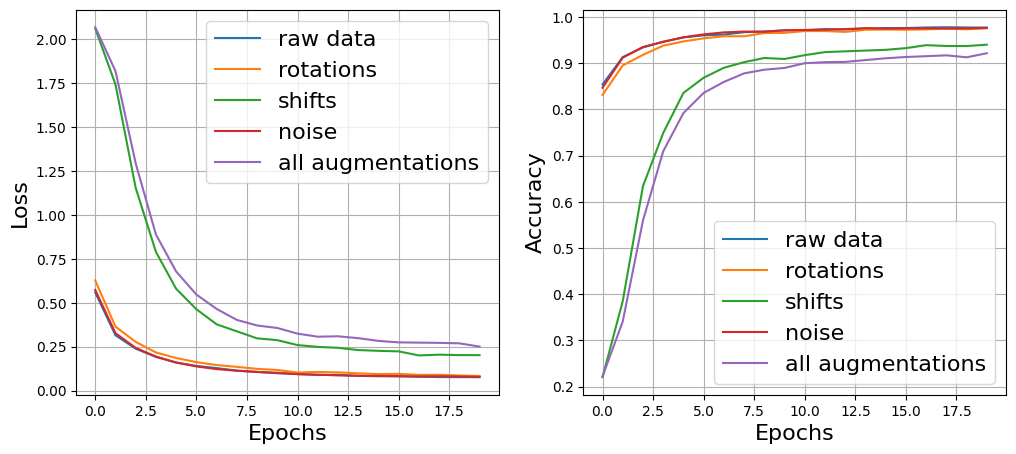

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.title('Loss')
plt.plot(ts_t, label='raw data')
plt.plot(ts_t_rot, label='rotations')
plt.plot(ts_t_aff, label='shifts')
plt.plot(ts_t_noise, label='noise')
plt.plot(ts_t_aug, label='all augmentations')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
# plt.title('Accuracy')
plt.plot(ts_ac_t, label='raw data')
plt.plot(ts_ac_t_rot, label='rotations')
plt.plot(ts_ac_t_aff, label='shifts')
plt.plot(ts_ac_t_noise, label='noise')
plt.plot(ts_ac_t_aug, label='all augmentations')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()